<a href="https://colab.research.google.com/github/comchem/Pytorch_DeepLearning_Tutorials/blob/master/Sec7-NLP_ANN/3-Text_Classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext.legacy.data as ttd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
!git clone https://github.com/comchem/Pytorch_DeepLearning_Tutorials.git

Cloning into 'Pytorch_DeepLearning_Tutorials'...
remote: Enumerating objects: 197, done.
remote: Counting objects: 100% (197/197), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 197 (delta 93), reused 3 (delta 0), pack-reused 0
Receiving objects: 100% (197/197), 2.71 MiB | 11.77 MiB/s, done.
Resolving deltas: 100% (93/93), done.


In [3]:
path = './Pytorch_DeepLearning_Tutorials/data/spam.csv'
df = pd.read_csv(path, encoding='ISO-8859-1')

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [6]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# rename columns to something better
df.columns = ['labels', 'data']

In [8]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
# create binary labels
df['b_labels'] = df['labels'].map({'ham':0, 'spam':1})

In [11]:
df2 = df[['data', 'b_labels']]

In [12]:
df2.head()

,data,b_labels
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [13]:
df2.to_csv('spam2.csv', index=False)

In [14]:
TEXT = ttd.Field(sequential = True, batch_first = True, lower = False, pad_first = True)
LABEL = ttd.Field(sequential = False, use_vocab = False, is_target = True)

# Note: if you don't specify use_vocab = False, then Pytorch will complain later when you try 
# to iterate over the dataset that the attribute 'vocab' doesn't exist.

# Note 2: if you don't specify is_target = True, then Pytorch will assume it's part of the input,
# so when you iterate over the dataset it will be like:
# for (inputs, targets), _ in iterator:
# where the 2nd element (_) should have been the target.

dataset = ttd.TabularDataset(
    path = 'spam2.csv',
    format = 'csv',
    skip_header = True,
    fields = [('data', TEXT), ('label', LABEL)]
)

In [15]:
train_dataset, test_dataset = dataset.split()  # default is 0.7

In [16]:
TEXT.build_vocab(train_dataset)

In [17]:
vocab = TEXT.vocab

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [19]:
train_iter, test_iter = ttd.Iterator.splits(
    (train_dataset, test_dataset), sort_key = lambda x: len(x.data),
    batch_sizes = (32,256), device = device)

In [20]:
# What is the shape of embedding output?
# N x T x D
embed = nn.Embedding(len(vocab), 20).to(device)
for inputs, targets in train_iter:
  out = embed(inputs)
  print("input shape:", inputs.shape, "output shape:", out.shape)
  break

input shape: torch.Size([32, 56]) output shape: torch.Size([32, 56, 20])


In [31]:
# Define the model
class CNN(nn.Module):
  def __init__(self, n_vocab, embed_dim, n_outputs):
    super(CNN, self).__init__()
    self.V = n_vocab
    self.D = embed_dim
    self.K = n_outputs

    # if input is T words
    # then output is (T, D) matrix
    self.embed = nn.Embedding(self.V, self.D)

    # define the conv layers
    self.conv1 = nn.Conv1d(in_channels=self.D, out_channels=32, kernel_size=3, padding=1)
    self.pool1 = nn.MaxPool1d(2)
    self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.pool2 = nn.MaxPool1d(2)
    self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

    self.fc = nn.Linear(128, self.K)

  def forward(self, X):
    # embedding layer
    # turns word indexes into word vectors
    out = self.embed(X)

    # note: output of embedding is always
    # (N, T, D)
    # conv1d expects
    # (N, D, T)

    # conv layers
    out = out.permute(0,2,1)
    out = self.conv1(out)
    out = F.relu(out)
    out = self.pool1(out)
    out = self.conv2(out)
    out = F.relu(out)
    out = self.pool2(out)
    out = self.conv3(out)
    out = F.relu(out)

    # change it back
    out = out.permute(0,2,1)

    # max pool
    out, _ = torch.max(out, 1)

    # final dense layer
    out = self.fc(out)
    return out

In [32]:
model = CNN(len(vocab), 20, 1)
model.to(device)

CNN(
  (embed): Embedding(12553, 20)
  (conv1): Conv1d(20, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [33]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [34]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_iter, test_iter, epochs):

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_iter:
      # print("inputs.shape:", inputs.shape, "targets.shape:", targets.shape)
      # move data to GPU  
      # inputs, targets = inputs.to(device), targets.to(device)
      targets = targets.view(-1, 1).float()

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
      
    # Get train loss and test loss
    train_loss = np.mean(train_loss)   # a little misleading

    test_loss = []
    for inputs, targets in test_iter:
      #inputs, targets = inputs.to(device), targets.to(device)
      targets = targets.view(-1,1).float()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0      
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [37]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_iter, test_iter, 8)

Epoch 1/15, Train Loss: 0.0211, Test Loss: 0.1087, Duration: 0:00:00.421729
Epoch 2/15, Train Loss: 0.0110, Test Loss: 0.1310, Duration: 0:00:00.407695
Epoch 3/15, Train Loss: 0.0075, Test Loss: 0.1517, Duration: 0:00:00.401516
Epoch 4/15, Train Loss: 0.0058, Test Loss: 0.1558, Duration: 0:00:00.400136
Epoch 5/15, Train Loss: 0.0059, Test Loss: 0.1250, Duration: 0:00:00.405066
Epoch 6/15, Train Loss: 0.0030, Test Loss: 0.1248, Duration: 0:00:00.406870
Epoch 7/15, Train Loss: 0.0023, Test Loss: 0.1408, Duration: 0:00:00.406332
Epoch 8/15, Train Loss: 0.0015, Test Loss: 0.1526, Duration: 0:00:00.399650
Epoch 9/15, Train Loss: 0.0010, Test Loss: 0.1515, Duration: 0:00:00.404904
Epoch 10/15, Train Loss: 0.0014, Test Loss: 0.1404, Duration: 0:00:00.402447
Epoch 11/15, Train Loss: 0.0006, Test Loss: 0.1841, Duration: 0:00:00.410557
Epoch 12/15, Train Loss: 0.0005, Test Loss: 0.1631, Duration: 0:00:00.405533
Epoch 13/15, Train Loss: 0.0003, Test Loss: 0.1612, Duration: 0:00:00.396716
Epoch 14

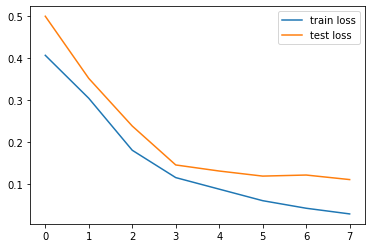

In [36]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [38]:
# Accuracy

n_correct = 0.
n_total = 0.
for inputs, targets in train_iter:
    targets = targets.view(-1, 1).float()
    
    # Forward pass
    outputs = model(inputs)
    #print(outputs.shape)
    
    # Get prediction
    predictions = (outputs > 0)
    # print(_, predictions)
    
    # update counts
    n_correct += (predictions == targets).sum().item()   # item : sum까지만 하면 출력이 tensor로 표현되므로 합산만 뽑아냄
    n_total += targets.shape[0]
    
train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_iter:
    targets = targets.view(-1, 1).float()

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    predictions = (outputs > 0)
    
    # update counts
    n_correct += (predictions == targets).sum().item()   # item : sum까지만 하면 출력이 tensor로 표현되므로 합산만 뽑아냄
    n_total += targets.shape[0]
    
test_acc = n_correct / n_total
print(f'Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}')

Train acc: 1.0000, Test acc: 0.9659
